<a href="https://colab.research.google.com/github/snehalad/nlp-text-summarizer-project/blob/main/NLP_text_summarizer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2 : SkimLit 📰🔥

The Purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset thet we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1c338767-5e69-a195-b748-066cba6baace)


## Get Data

Since we'll replicating the paper above (PubMed 200k RCT), let's download the dataset they used.
We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# check what files are in the PubMed_20kdataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/ # replace number with sign
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# start our experiments using the 20k dataset with numbers replaced by @ sign 
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# check all of the filesnames in the taget directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt']

## Preprocess Data 



In [ ]:
# create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list
  Args:
    filename : a tring containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# let's read in the training lines
train_lines = get_lines(data_dir+"/train.txt") 
train_lines[:20]

NameError: ignored

In [ ]:
len(train_lines)

Let's think about how we want our data to look...

How i think our data would be best reprented...

```
  [{'line_number':0 ,
 
    'target':'BACKGROUND',

    'text':'Emotional eating is associated with overeating and the development of obesity .',

    'total_lines':11},
    ...]
```

Let's write a function which turn each of our datasets into the above format so we can continue to prepare 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sort through each line, 
  extarcting things like target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence 
  number the target lines
  """
  input_lines = get_lines(filename) # get all lines from filename 
  abstract_lines = "" # create an empty abstarct
  abstarct_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if is an ID line
      abstarct_id = line
      abstarct_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace():
      abstarct_line_split = abstarct_lines.splitlines() # split abstarct into separate lines

      # Interate through each line in a single abstarct and count them at the same time
      for abstarct_line_number, abstract_line in enumerate(abstarct_line_split):
        line_data = {} # create an empty directory for each line 
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstarct_line_number # what number line does the line apper in the abstarct?
        line_data["total_lines"] = len(abstarct_line_split) - 1 # how many total lines are there in the target abstarct
        abstarct_samples.append(line_data)

    else: # if above condition are'nt fullfill
      abstarct_lines += line

  return abstarct_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")

In [ ]:
# check the first abstarct of our training data
train_samples[:14]

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

## Get Lists of Sentences

In [ ]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# view the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels(ML Models require numeric Labels)

### OneHotEncoder

In [ ]:
# one hot encoder labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-saparse matrix
train_lables_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_lables_one_hot

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode Labels

In [ ]:
# exatract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting a Series of Modelling Experiments....

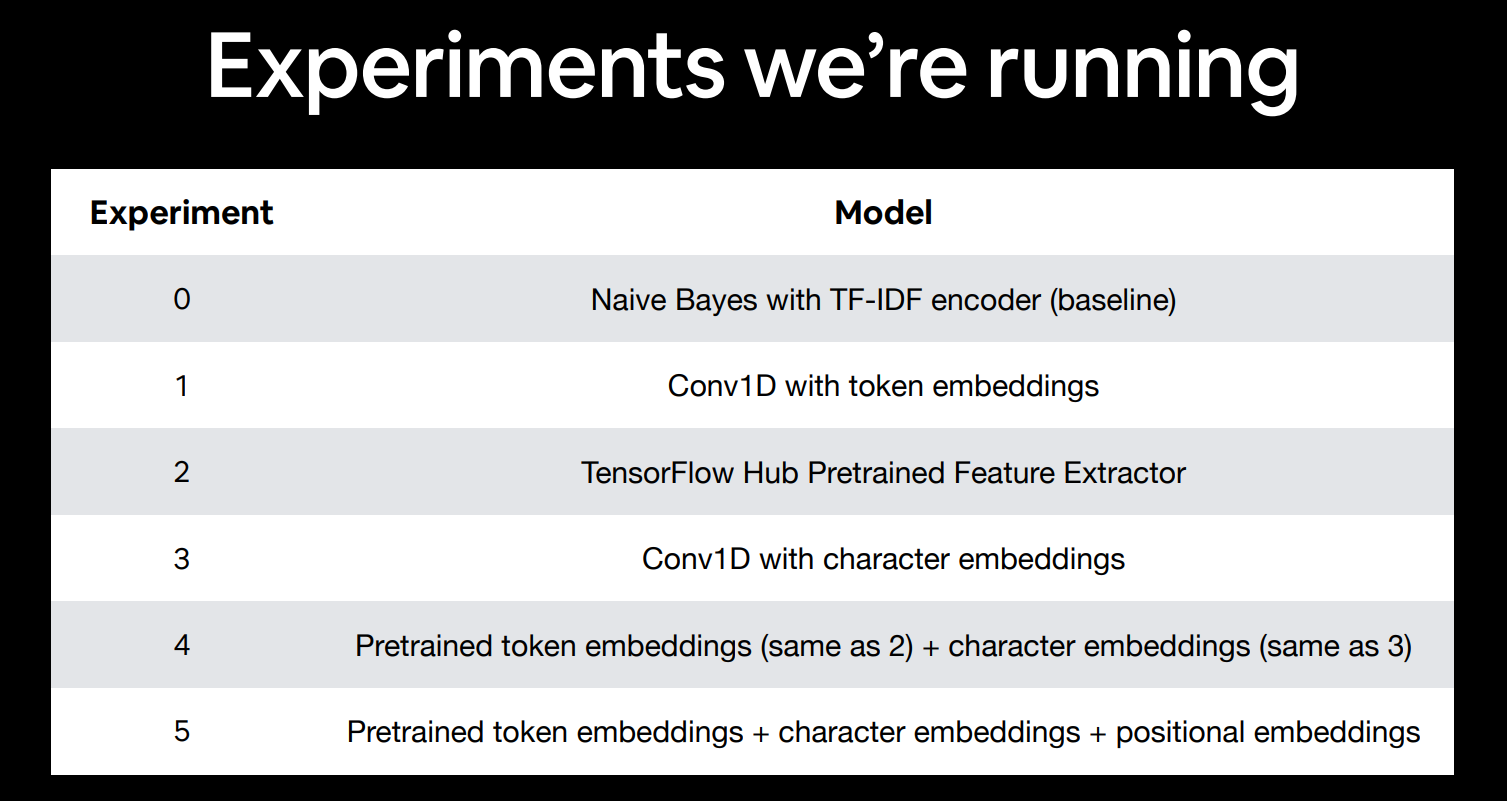



## Model 0 : Getting a Baseline
baseline(TF-IDF Multinominal Naive Bayes Classifier)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# fit the pipeline to training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evaluate baseline model on valiadation datatset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# make predictions using our baseleine model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-17 05:07:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-17 05:07:46 (42.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing our data (the text) of deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

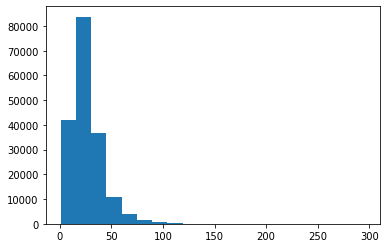

In [ ]:
# what's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
# how long of a sentence lenght covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# maximum sequence length in the training set
max(sent_lens)

296

# Create text Vectorizer layer
We want to make a layer which maps our texts from words to number

In [ ]:
# how many words are in our vocab? (taken from table 2 in: https://arxiv.org/abs/1710.06071 pdf)
max_tokens = 68000

In [ ]:
# create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# adapt text vectorizer to taining data
text_vectorizer.adapt(train_sentences)

In [ ]:
# test out text vectorization on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the study was terminated early because of safety concerns ( hypoglycaemia ) .

Length of text: 13

Vectorized text: [[   2   17   10 4461  224  542    4  136 1713 4239    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

# Create Custom text Embedding

In [ ]:
# create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
# show example embedding 
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sen = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sen}")
embeded_sen = token_embed(vectorized_sen)
print(f"Sentence after embedding:\n{embeded_sen}")
print(f"Embeded Sentence shape:{embeded_sen.shape}")

Sentence before vectorization:
the study was terminated early because of safety concerns ( hypoglycaemia ) .

Sentence after vectorization (before embedding):
 [[   2   17   10 4461  224  542    4  136 1713 4239    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding:
[[[ 0.01328746  0.04259384 -0.02139454 ...  0.0100982   0.03442068
    0.0496765 ]
  [-0.03396501 -0.02917922 -0.03281844 ...  0.02821929  0.02789005
    0.0305598 ]
  [-0.0038735  -0.01884311 -0.03462338 ... -0.03313265  0.04813815
   -0.0348335 ]
  ...
  [ 0.04725363 -0.04344726  0.04700173 ... -0.02180071  0.04626748
    0.01354487]
  [ 0.04725363 -0.04344726  0.04700173 ... -0.02180071  0.04626748
    0.01354487]
  [ 0.04725363 -0.04344726  0.04700173 ... -0.02180071  0.04626748
    0.01354487]]]
Embeded Sentence shape:

# Creating datasets (making sure our data loads as fast as possible)

we're going to setup our data to run as fast as possible with the Tensorflow tf.data API, many of steps here discussed at length in these two resources:


- https://www.tensorflow.org/guide/data
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- https://www.tensorflow.org/guide/data_performance

In [ ]:
# Turn our data into Tensorflow Datasets (create dataset)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_lables_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# take the tensorSliceDataset and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D with token embedding

We're trying to implement model from https://arxiv.org/pdf/1612.05251.pdf

In [ ]:
# create 1D conv model to process sequences 
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 5)                 325

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
len(train_dataset)

5627

In [ ]:
5627*32

180064

In [ ]:
# fit the model 
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only 10% data we're fitting

Epoch 1/3
562/562 [==============================] - 22s 37ms/step - loss: 0.9180 - accuracy: 0.6373 - val_loss: 0.6865 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6607 - accuracy: 0.7536 - val_loss: 0.6354 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6203 - accuracy: 0.7737 - val_loss: 0.5974 - val_accuracy: 0.7806


In [ ]:
# evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6002 - accuracy: 0.7858


[0.6002498269081116, 0.785813570022583]

In [ ]:
# make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.2983112e-01, 1.6752006e-01, 8.8078886e-02, 2.8344977e-01,
         3.1120254e-02],
        [4.3048108e-01, 2.6763126e-01, 1.1870126e-02, 2.8142869e-01,
         8.5888356e-03],
        [1.4160040e-01, 6.5498352e-03, 1.9861769e-03, 8.4981567e-01,
         4.7951431e-05],
        ...,
        [4.6767937e-06, 6.7947869e-04, 6.8605511e-04, 3.1472018e-06,
         9.9862671e-01],
        [5.9018828e-02, 4.6410322e-01, 9.4440453e-02, 7.7438384e-02,
         3.0499905e-01],
        [1.8290985e-01, 6.4753181e-01, 4.5139607e-02, 5.2160494e-02,
         7.2258219e-02]], dtype=float32), (30212, 5))

In [ ]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.58135840063551,
 'precision': 0.782750672344357,
 'recall': 0.785813584006355,
 'f1': 0.7836529439223097}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretraintedtoken embeddings

Now lets pretrained word embeddings from TensorFlow Hub, more specifically the universal senetnce encoder(USE):
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originalyy used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings

### USE (Universal Sentence Encoder)

In [ ]:
# download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence\n {random_train_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Senetence after embedding:\n {use_embedding_sentence[0][:10]}")
print(f"Length of senetnce embedding: {len(use_embedding_sentence[0])}")

Random Sentence
 at postoperative @ day , the mean subjective pain score in the lasek group was @ @ and @ @ in t-prk group ( p = @ ) .
Senetence after embedding:
 [-0.01897516 -0.03970673  0.06986898 -0.01593516  0.03694129  0.04246538
 -0.04577946  0.02787056 -0.02121572  0.00583505]
Length of senetnce embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [ ]:
# Define feature extarction model using TF Hub layers
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could ass more layers here if you want
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs, 
                         name="model_2_USE_feature_extarctor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extarctor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_16 (Dense)            (None, 128)               65664     
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9164 - accuracy: 0.6491 - val_loss: 0.7987 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7705 - accuracy: 0.7008 - val_loss: 0.7578 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7550 - accuracy: 0.7115 - val_loss: 0.7429 - val_accuracy: 0.7111


In [ ]:
# evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7441 - accuracy: 0.7119


[0.7441499829292297, 0.7119025588035583]

In [ ]:
# make predictions with feature extarction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[0.43377888, 0.37336078, 0.0033406 , 0.17929919, 0.01022062],
       [0.3396733 , 0.506762  , 0.00510137, 0.1445207 , 0.00394259],
       [0.22466749, 0.14928862, 0.01878299, 0.5689832 , 0.03827773],
       ...,
       [0.00194475, 0.00524373, 0.05788098, 0.00101515, 0.9339154 ],
       [0.00389561, 0.04808702, 0.20048116, 0.00177042, 0.7457658 ],
       [0.17769536, 0.24742201, 0.5057511 , 0.00716125, 0.06197031]],
      dtype=float32)

In [ ]:
# convert the prediction probabilities found with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.19025552760493,
 'precision': 0.7127440055388621,
 'recall': 0.7119025552760493,
 'f1': 0.709268403690842}

## Model 3: Conv1D with character embedding

The paper which we're replicating states they used a combination of token and characters-level embedding

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embedding

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# make function to split sentences into characters
def split_char(text):
  return " ".join(list(text))

# text splitting non-charcter-level sequence into chracters
split_char(random_train_sentence)

'a t   p o s t o p e r a t i v e   @   d a y   ,   t h e   m e a n   s u b j e c t i v e   p a i n   s c o r e   i n   t h e   l a s e k   g r o u p   w a s   @   @   a n d   @   @   i n   t - p r k   g r o u p   (   p   =   @   )   .'

In [ ]:
# split sequence-level data split into charcter-level data split
train_char = [split_char(sentence) for sentence in train_sentences]
val_char = [split_char(sentence) for sentence in val_sentences]
test_char = [split_char(sentence) for sentence in test_sentences]

train_char[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# what's the average character lenght?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

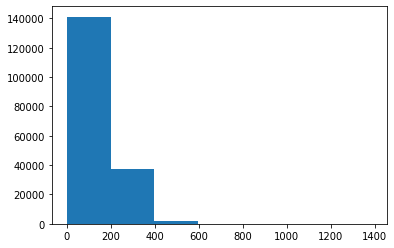

In [ ]:
# check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
# find what character lengh covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# get all keyword charcters 
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
# create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add for space and ovv(out od vacb)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# adapt character vectorizer to training  character
char_vectorizer.adapt(train_char)

In [ ]:
# check character vocab stats 
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 Most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out charcters vectorizer
random_train_chars = random.choice(train_char)
print(f"Charified text\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars)}")

Charified text
 t h e   p r i m a r y   e n d p o i n t   w a s   i n f a r c t   v o l u m e   o n   m r i   a t   @   d a y s   .

Length of random_train_chars: 115

Vectorized chars:
 [[ 3 13  2 14  8  4 15  5  8 19  2  6 10 14  7  4  6  3 20  5  9  4  6 17
   5  8 11  3 21  7 12 16 15  2  7  6 15  8  4  5  3 10  5 19  9  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0



### Creating a character-level embedding

- Why we are using character-level embedding?
Actually we're trying to implement fig-1 from this paper https://arxiv.org/pdf/1612.05251.pdf 


In [ ]:
# create a character-level embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # no of differnt character
                              output_dim=25, # character embeddings (25),from paper
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# test our character embedding layers
print(f"charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embeded chars (after vectorizer and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

charified text:
 t h e   p r i m a r y   e n d p o i n t   w a s   i n f a r c t   v o l u m e   o n   m r i   a t   @   d a y s   .
Embeded chars (after vectorizer and embedding):
 [[[ 0.01498527 -0.02451283  0.0197187  ... -0.02910572  0.01953833
    0.01646556]
  [ 0.00947306  0.00410401  0.04781404 ... -0.02638255  0.03737655
   -0.00144106]
  [ 0.04536526 -0.0108813   0.04185728 ...  0.00658875 -0.03482383
   -0.04943947]
  ...
  [-0.00703483 -0.01074599  0.03115053 ...  0.01519532 -0.0407163
   -0.03547726]
  [-0.00703483 -0.01074599  0.03115053 ...  0.01519532 -0.0407163
   -0.03547726]
  [-0.00703483 -0.01074599  0.03115053 ...  0.01519532 -0.0407163
   -0.03547726]]]
Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embedding

In [ ]:
from keras.layers.attention.multi_head_attention import activation
# make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# compile 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 

In [ ]:
train_char[:2], train_lables_one_hot[:2]

(['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
  'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'],
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]]))

In [ ]:
# create char level datasets
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_char, train_lables_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_char, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_datasets

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# fit the model on chars only
model_3_history = model_3.fit(train_char_datasets,
                              steps_per_epoch=int(0.1*len(train_char_datasets)),
                              epochs=3,
                              validation_data=val_char_datasets,
                              validation_steps=int(0.1*len(val_char_datasets)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2417 - accuracy: 0.5068 - val_loss: 1.0148 - val_accuracy: 0.6064
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9861 - accuracy: 0.6114 - val_loss: 0.9273 - val_accuracy: 0.6433
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9187 - accuracy: 0.6406 - val_loss: 0.8526 - val_accuracy: 0.6809


In [ ]:
# make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_datasets)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.07819937, 0.57341367, 0.06203098, 0.14546807, 0.1408879 ],
       [0.23495896, 0.46125457, 0.02563229, 0.23727326, 0.04088083],
       [0.07125391, 0.4519151 , 0.17393106, 0.11513069, 0.18776926],
       ...,
       [0.05004508, 0.05351594, 0.15176533, 0.05361101, 0.6910627 ],
       [0.03465034, 0.10895456, 0.31574243, 0.08231534, 0.45833737],
       [0.45694637, 0.39509726, 0.07446077, 0.06185215, 0.01164341]],
      dtype=float32)

In [ ]:
# convert prediction probaabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.34449887461936,
 'precision': 0.6577164673867891,
 'recall': 0.6634449887461936,
 'f1': 0.6541215817806492}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Concatenate,
from keras.api._v2.keras.layers import concatenate
## Model 4: Combining pretrained token embeddings + characters embeddings (hybride embedding layer)

1. Create a token-level embedding model (similar model_1)
2. Create a character-level model (similar to model_3 with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to figure 1 and section4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Constarct a model which takes token and charaters-level sequences as input and produces sequence label probabilities as outout

In [ ]:
# 1. setup token input/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_ltsm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #character embeddings (25) but we are using multiply of 8
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_ltsm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concate = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                   char_model.output])

# 4. Create output layers - adding in dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concate)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constract model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
# summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

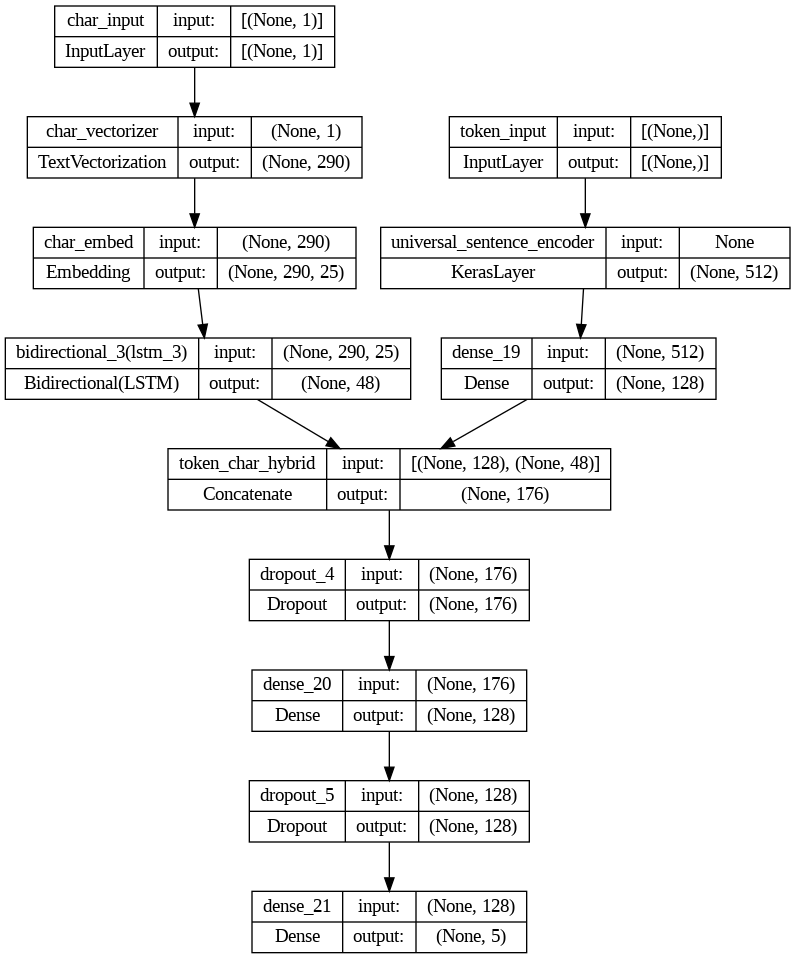

In [ ]:
# plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into tf.data Dataset


In [ ]:
# combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_lables_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_token_char_data, train_char_token_labels)) # combine both

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# repeat above steps for valiadation
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_char)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_token_char_data, val_char_token_labels)) # combine both

# prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# checkout our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences


In [ ]:
# fit model on token and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 50ms/step - loss: 0.9808 - accuracy: 0.6115 - val_loss: 0.7827 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7958 - accuracy: 0.6937 - val_loss: 0.7179 - val_accuracy: 0.7277
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7803 - accuracy: 0.7036 - val_loss: 0.6879 - val_accuracy: 0.7440


In [ ]:
# evalaute on whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6936 - accuracy: 0.7379


[0.69363933801651, 0.7378525137901306]

In [ ]:
# make predictions using the token-character modelhybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 18ms/step


array([[5.4398298e-01, 2.5464332e-01, 3.4592915e-03, 1.9406040e-01,
        3.8540263e-03],
       [3.5596234e-01, 4.1360116e-01, 6.0839658e-03, 2.2184442e-01,
        2.5081488e-03],
       [3.1691778e-01, 1.2872884e-01, 4.5623578e-02, 4.8025349e-01,
        2.8476322e-02],
       ...,
       [7.9672993e-04, 8.5429456e-03, 5.0063282e-02, 2.3862266e-04,
        9.4035840e-01],
       [4.2854855e-03, 4.0301260e-02, 2.0775983e-01, 1.7160975e-03,
        7.4593729e-01],
       [3.5272369e-01, 3.8922453e-01, 1.9170082e-01, 3.3422019e-02,
        3.2929000e-02]], dtype=float32)

In [ ]:
# format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# result for model 4
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.78525089368463,
 'precision': 0.7375458908961698,
 'recall': 0.7378525089368463,
 'f1': 0.736360558905463}

In [ ]:
model_1_results

{'accuracy': 78.58135840063551,
 'precision': 0.782750672344357,
 'recall': 0.785813584006355,
 'f1': 0.7836529439223097}

## Model 5: Transfer Learning with pretrained token embeddings + character embedding + positional embeddings


*Feature engineering* is a machine learning technique that leverages data to create new variables that aren't in the training set.



In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑**Note** Any engineered features used to train a model need to be available at test time. 
In Our case, the line numbers and total lines are avaialable.

### Create positional embeddings

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

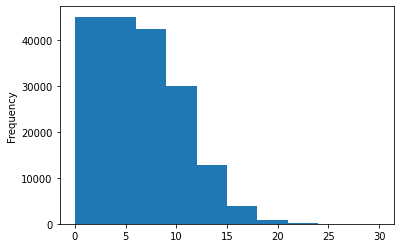

In [ ]:
# check the distribution of line_number column
train_df.line_number.plot.hist()

In [ ]:
# use tensorflow to create one hot encodding
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot.shape

TensorShape([180040, 15])

Now we've encoded our line numbers features, let's do the same for our total lines feature...

In [ ]:
# how many different line are?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

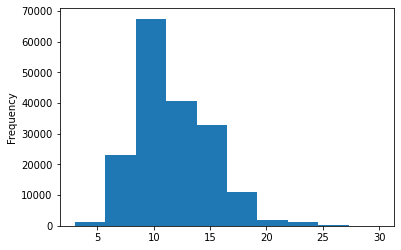

In [ ]:
# check out distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# check the coverage of a total_lines 
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# use tensorflow to create one-hot-encoded 
train_total_line_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_line_one_hot.shape, train_total_line_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Build a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probaabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a `tf.keras.Model` 

In [ ]:
# for line_number_model
train_line_numbers_one_hot[0].shape, train_line_numbers_one_hot.dtype

(TensorShape([15]), tf.float32)

In [ ]:
# for total_lines model
train_total_line_one_hot[0].shape, train_total_line_one_hot.dtype

(TensorShape([20]), tf.float32)

In [ ]:
# 1. token input
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_ltsm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_ltsm)

# 3. line numbers model
line_number_inputs = layers.Input((15,), dtype=tf.float32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, 
                                   outputs=line_number_outputs)

# 4. total lines model
total_lines_inputs = layers.Input((20,), dtype=tf.float32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, 
                                   outputs=total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

# For regularization, dropoutwith a rate of 0.5 is applied
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(rate=0.5)(z)

# 6. combine positional embedding with combined token and char embedding
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. put together model with all kind of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
# summary
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

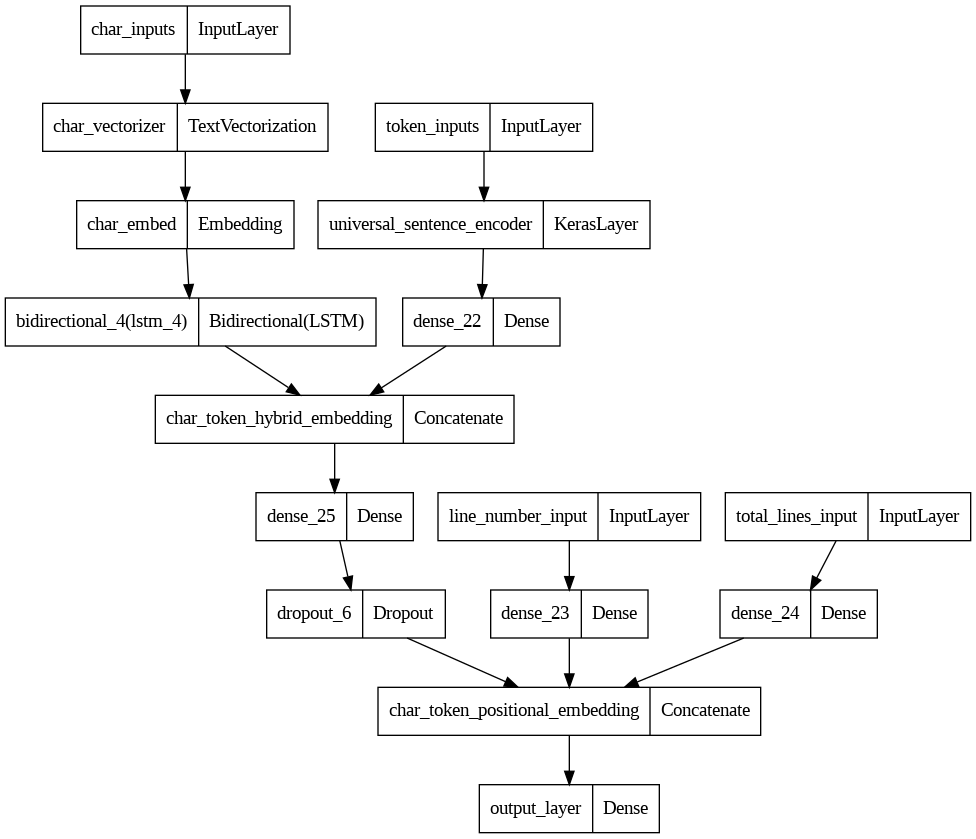

In [ ]:
from keras.utils import plot_model
plot_model(model_5)

what is label smoothing?

For example, if our model gets too confident on single class (e.g its prediction probability is really high), it may stuck on that class and not consider other classes...

Really confident : [0.0, 0.0, 1.0, 0.0, 0.0]

what label smothing does is it assigns some of the value from the highest pred prob to other classes, in turn hopefully improving generalization: [0.01, 0.01, 0.96, 0.01, 0.01,]

https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [ ]:
# create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_line_one_hot,
                                                                train_sentences,
                                                                train_char))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_lables_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_pos_char_token_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# do the same for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_line_one_hot,
                                                              val_sentences,
                                                              val_char))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_pos_char_token_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<ZipDataset element_spec=((TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <ZipDataset element_spec=((TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 52ms/step - loss: 1.0942 - accuracy: 0.7258 - val_loss: 0.9821 - val_accuracy: 0.8009
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9663 - accuracy: 0.8171 - val_loss: 0.9507 - val_accuracy: 0.8285
Epoch 3/3
562/562 [==============================] - 23s 42ms/step - loss: 0.9514 - accuracy: 0.8220 - val_loss: 0.9386 - val_accuracy: 0.8305


In [ ]:
# make prediction with the char token pos model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[0.47836643, 0.1002402 , 0.01078268, 0.3936095 , 0.01700119],
       [0.54651433, 0.09480958, 0.04312029, 0.30660713, 0.00894866],
       [0.29862824, 0.10963944, 0.14187749, 0.37012506, 0.07972989],
       ...,
       [0.03058453, 0.10031484, 0.04047126, 0.02874914, 0.79988027],
       [0.02951416, 0.2979188 , 0.07290934, 0.02926891, 0.5703888 ],
       [0.17830251, 0.5934965 , 0.1154953 , 0.0438562 , 0.06884952]],
      dtype=float32)

In [ ]:
# convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# calculate results of char token pos model 
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.3443664768966,
 'precision': 0.832687201916737,
 'recall': 0.8334436647689659,
 'f1': 0.8324306114382476}

# Compare model results

In [ ]:
# combine results into a dataframe
all_model_result = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_custom_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_custom_char_embedding": model_3_results,
                                 "model_4_hybrid_char_token_embedding": model_4_results,
                                 "model_5_pos_char_token_embedding": model_5_results})
all_model_result = all_model_result.transpose()
all_model_result

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.581358,0.782751,0.785814,0.783653
model_2_pretrained_token_embedding,71.190256,0.712744,0.711903,0.709268
model_3_custom_char_embedding,66.344499,0.657716,0.663445,0.654122
model_4_hybrid_char_token_embedding,73.785251,0.737546,0.737853,0.736361
model_5_pos_char_token_embedding,83.344366,0.832687,0.833444,0.832431


In [ ]:
# reduce the accuracy to same scale as other metrics
all_model_result['accuracy'] = all_model_result['accuracy']/100

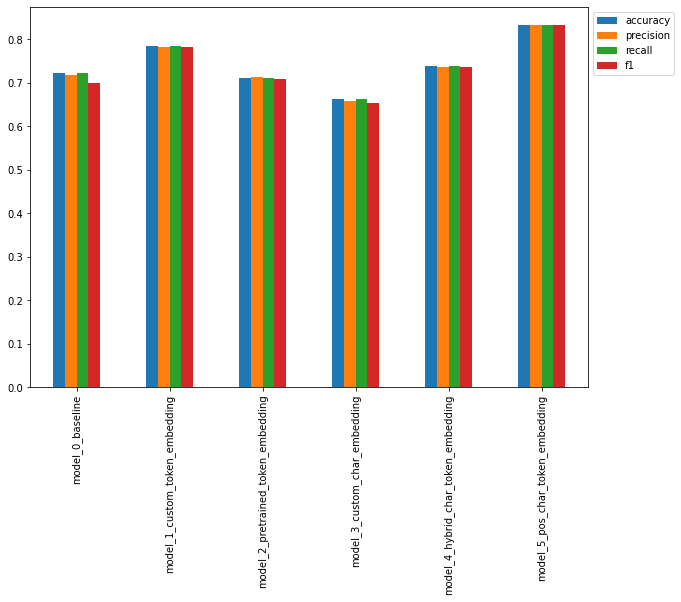

In [ ]:
# plot and compare all model results
all_model_result.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

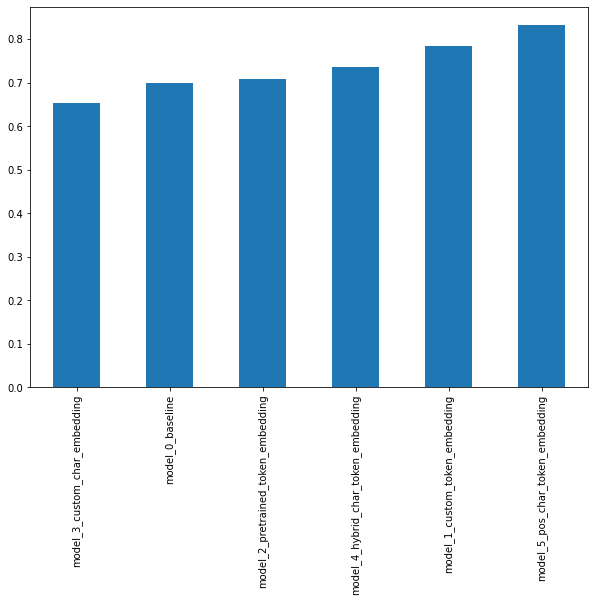

In [ ]:
# sort models results by f1-score
all_model_result.sort_values('f1', ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

# Save and load model

In [ ]:
# save the best performing model
model_5.save("skimlit_tribrid_model")

In [ ]:
# load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# make prediction with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 20s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# calculate results of loaded model
loaded_model_result = calculate_results(val_labels_encoded,
                                        loaded_preds)
loaded_model_result

{'accuracy': 83.3443664768966,
 'precision': 0.832687201916737,
 'recall': 0.8334436647689659,
 'f1': 0.8324306114382476}

In [ ]:
assert model_5_results == loaded_model_result

In [ ]:
# evaluate model
loaded_model.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 22s 19ms/step - loss: 0.9369 - accuracy: 0.8334


[0.936902642250061, 0.8334436416625977]